# Статистика, DS-поток
## Практическое задание 6


**Правила:**

* Дедлайн **19 октября 16:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 &mdash; 5 баллов
* Задача 2 &mdash; 5 баллов
* Задача 3 &mdash; 5 баллов
* Задача 4a &mdash; 5 баллов
* Задача 4b &mdash; 10 баллов

**Важность задач:**

* *высокая:* задачи 1, 2, 3;
* *средне-высокая:* задача 4.

*Замечания.*
1. Вы должны помнить о разнице между доверительным интервалом и *реализацией* доверительного интервала. На практике обычно слово *реализация* опускается.
2. Если интервал получен на лекции/семинаре, то нужно просто выписать его формулу. Если такой случай не рассматривался, то нужно добавить его вывод.
3. Выборку надо сгенерировать один раз. Дело в том, что на практике при недостаточном размере выборки разумнее дособрать выборку, чем заново проводить все измерения.

In [122]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(font_scale=1.5, palette='Set2')
sns.set_style('whitegrid')

import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
%matplotlib inline

In [123]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [124]:
%ls
%cd 'gdrive/MyDrive/DS/task6'
%ls

plot.html  task6.ipynb  weather/
[Errno 2] No such file or directory: 'gdrive/MyDrive/DS/task6'
/content/gdrive/MyDrive/DS/task6
plot.html  task6.ipynb  weather/


______________

##Несколько полезных функций на будущее

In [138]:
def cumulative_average(sample):
    return sample.cumsum() / np.arange(1, sample.size + 1)

def cumulative_median(sample):
    return np.array([np.median(sample[:i]) for i in range(1, sample.size + 1)])

def cumulative_max(sample):
    return np.maximum.accumulate(sample)

def cumulative_S(sample):
    return cumulative_average(sample**2) - cumulative_average(sample)**2

# первая и вторая производная для log-likelihood распределения Коши с лекции
# код из предыдущей домашки
def log_likelihood_1st_d(sample, estimation):
  X = sample - estimation
  return -(X / (1 + X**2)).sum()

def log_likelihood_2nd_d(sample, estimation):
  X = sample - estimation
  return ((1 - X**2) / (1 + X**2)**2).sum()

def one_step(sample, estimator):
  estimation = estimator(sample)
  ans = [estimation[i] - log_likelihood_1st_d(sample[:i+1], estimation[i]) / log_likelihood_2nd_d(sample[:i+1], estimation[i]) for i in range(sample.size)]
  return np.array(ans)

______________
## Задача 1.

В этой задаче нужно визуализировать доверительные интервалы для выборки из равномерного распределения.

Чтобы не плодить код, напишите следующую функцию (см. ниже). При выборе стиля графика помните, что если изображаются лишь точки и линии, то лучше использовать серый фон, а если присутствуют закрашенные области, то предпочтительнее белый. Графики первого типа еще называют "легкими", а второго — "тяжелыми".

In [142]:
def draw_confidence_interval(
    left, right, estimation=None, real_theta=None, sample=None, 
    ylim=(None, None), color_estimation='#FF3300', color_interval='#00CC66', 
    color_sample='#0066FF', color_theta='#000000', label_estimation='Оценка',
    filename=None
):
    '''
    Рисует доверительный интервал и оценку в зависимости от размера выборки.
    
    :param left: левые границы интервалов (в зависимости от n)
    :param right: правые границы интервалов (в зависимости от n)
    :param estimation: оценки (в зависимости от n)
    :param real_theta: реальное значение параметра
    :param sample: выборка
    :param ylim: ограничение вертикальной оси
    :param color_estimation: цвет оценки
    :param color_interval: цвет интервала
    :param color_sample: цвет выборки
    :param label_estimation: подпись для оценки
    '''
    x = np.arange(1, left.size + 1)

    fig = go.Figure([
        go.Scatter(
            x=np.concatenate((x, x[::-1])), # x, then x reversed
            y=np.concatenate((left, right[::-1])), # upper, then lower reversed
            fill='toself',
            fillcolor=color_interval,
            opacity=0.5,
            line=dict(color=color_interval),
            name='Доверительный интервал',
            line_shape='spline',
            line_smoothing=0.25
        )
    ])

    if estimation is not None:
        fig.add_trace(
            go.Scatter(
                x=x,
                y=estimation,
                line=dict(color=color_estimation),
                mode='lines',
                name=label_estimation,
                line_shape='spline',
                line_smoothing=0.25
            )
        )
    
    if sample is not None:
        fig.add_trace(
            go.Scatter(
                x=x,
                y=sample,
                line=dict(color=color_sample),
                mode='markers',
                name='Выборка',
            )
        )
    
    if real_theta is not None:
        # fig.add_hline(
        #     y=0.9,
        #     line=dict(color=color_sample),
        # ) # начиная c plotly.__version__  4.12
        fig.add_trace(
            go.Scatter(
                x=x,
                y=np.full(x.shape, real_theta),
                line=dict(color=color_theta),
                mode='lines',
                name='Настоящее значение параметра',
            )
        )

    fig.update_layout(
        title_font_size=20,
        xaxis_title="Размер выборки",
        yaxis_title="Значение",
        plot_bgcolor='#FFFFFF',
        width=1000, height=600,
    )

    fig.update_xaxes(
        nticks=20,
        gridcolor='rgba(128,128,128,0.8)',
        linecolor='#000000',
        spikedash="dot", 
        spikemode="across", 
        showspikes=True, 
        spikecolor="#999999", 
        spikethickness=2,
        range=(0, left.size),
    )
    fig.update_yaxes(
        nticks=20,
        gridcolor='rgba(128,128,128,0.8)',
        linecolor='#000000',
        spikedash="dot", 
        spikemode="across", 
        showspikes=True, 
        spikecolor="#999999", 
        spikethickness=2
    )
    if ylim is not (None, None):
        fig.update_yaxes(
            range=ylim,
        )
    if filename is not None:
        py.plot(fig, filename=filename, auto_open=False)
    fig.show()

Пусть $X = (X_1, ..., X_n)$ &mdash; выборка из распределения $U[0, \theta]$. Постройте асимптотические доверительные интервалы: Вальда и на основе аппроксимации $X_{(n)}$ некоторым распределением. Для этого сгенерируйте выборку $X_1, ... X_{N}, N = 100$ и постройте график доверительных интервалов уровня доверия $0.95$, вычисленных для всех подвыборок размера $n$ вида $X_1, ... X_n$, $1 \le n \le 100$, используя написанную выше функцию. Нужно нанести на график точки выборки.

Для вычисления квантилей у каждого распределения из `scipy.stats` используйте функцию `ppf`.

Для двух статистик, используемых при построении интервалов, запишите аппроксимацию некоторым распределением неформально в виде "статистика по выборке достаточно большого размера приближенно имеет такое-то распределение". 

Сделайте вывод о том, как влияет на ширину интервала вид статистики и аппроксимация.

**Решение:**

В качестве а.н.о. для Вальда возьмем $2\overline{X}$. Асимптотическая дисперсия будет $\sigma^2(\theta) = \frac{\theta^2}{3} \implies \hat\sigma^2(\theta) = \frac{4\overline{X}^2}{3}$. Доверительный интервал $\left(2\overline{X} \pm z_{\frac{1+\alpha}{2}}\frac{2\overline{X}}{\sqrt{3n}}\right)$

Кроме того, из одной из домашек знаем, что $n(\theta - X_{(n)}) \overset{d_\theta}{\rightarrow} \xi \sim Exp(\frac{1}{\theta}) \implies n(1 - \frac{X_{(n)}}{\theta}) \overset{d_\theta}{\rightarrow} \eta \sim Exp(1) $

Сначала построим точный доверительный интервал для каждого n по результату задачи 1 Теор Задания 6, затем асимптотический интервал Вальда и последним будет интервал, основанный на аппроксимации максимума экспоненциальным распределением (далее апроксимированный интервал). В последнем случае методом центральной функции можно взять разные интервалы, возьмем для квантилей $\alpha_1 = \frac{1-\alpha}{2}; \alpha_1 = \frac{1+\alpha}{2}$ **на семинаре** получили интервал следующего вида: $ \left( \frac{X_{(n)}}{1-\frac{u_1}{n}}, \frac{X_{(n)}}{1-\frac{u_2}{n}}\right)$

Масштаб на графиках приведем к одному состоянию, чтобы видеть различия в "качестве" интервалов

In [166]:
theta = 1
N = 100
alpha = 0.95
szs = np.arange(1, N+1)

sample = sps.uniform.rvs(size=N, scale=theta)

In [167]:
X_n = cumulative_max(sample)
c_alpha = (1/(1-alpha))**(1/szs)
draw_confidence_interval(X_n, c_alpha*X_n, X_n*(szs + 1)/szs, theta, sample, ylim=(0.5, 1.5),
                         label_estimation='$X_{(n)}$', filename='./task6.1.interval1.html')

z = sps.norm.ppf(q=(1+alpha)/2)
average = cumulative_average(sample)
add = z * 2 * average / np.sqrt(3*szs)
draw_confidence_interval(2*average-add, 2*average+add, 2*average, theta, sample, ylim=(0.5, 1.5),
                         label_estimation='$2\\overline{X}$', filename='./task6.1.interval2.html')

alpha_1, alpha_2 = (1 - alpha) / 2, (1 + alpha) / 2
u_1, u_2 = sps.expon.ppf(q=(alpha_1, alpha_2))

draw_confidence_interval(X_n / (1-u_1/szs), X_n / (1-u_2/szs), X_n, theta, sample, ylim=(0.5, 1.5),
                         label_estimation='$X_{(n)}$', filename='./task6.1.interval3.html')

**Вывод:**

Точный интервал на основе $X_{(n)}$ несколько лучше, чем асимптотический, основанный на аппроксимации $X_{(n)}$ с помощью экспоненциального распределения. Однако, оба они, как можно заметить, лучше чем асимптотический интервал Вальда основанный на а.н.о. $2\overline{X}$

Можно объяснить это следующим:

1. Порядок уменьшения размера асимптотического интервала для Вальда - $\frac{1}{\sqrt{n}}$, а для аппроксимированного интервала $\frac{1}{n}$

2. Мы уже сравнивали поведедние различных оценок $\theta$ для $\mathbb{U}[0, \theta]$, и получали, что $2\overline{X}$ сильно проигрывал в среднеквадратичном подходе оценке $\frac{n+1}{n}X_{(n)}$

__________________
## Задача 2.
Аналогично задаче 1 сгенерируйте выборку $X_1, ... X_{100}$ из стандартного распределения Коши и постройте доверительные интервалы для следующих случаев:

* точный доверительный интервал минимальной длины в параметрической модели $\mathcal{N}(\theta, 1)$ (см. замечание ниже);
* точный асимптотический доверительный интервал в параметрической модели распределения Коши со сдвигом, используя выборочную медиану;
* точный асимптотический доверительный интервал в параметрической модели распределения Коши со сдвигом, используя асимптотически эффективную оценку.

Изобразите интервалы *на одном* графике полупрозрачными цветами. Точки выборки нужно нанести на график. 

*Замечание:*

1. Первый пример призван проиллюстрировать, что бывает, если используется неправильная модель. На практике вы никогда не знаете, из какого семейства распределений на самом деле получены данные.
**Решение:**

1. Точный доверительный интервал минимальной длины в модели $\mathcal{N}(\theta, 1)$

С лекции знаем, что точный доверительный интервал $\mathcal{N}(a, \sigma^2)$ при известной $\sigma$ - это $\left(\overline{X} \pm z_{\frac{1+\alpha}{2}}\frac{\sigma}{\sqrt{n}}\right) \overset{\text{В нашем случае}}{=} \left(\overline{X} \pm z_{\frac{1+\alpha}{2}}\frac{1}{\sqrt{n}}\right)$ 

При этом он будет минимален, так как на если есть другой отрезок $ U = (u_1, u_2)$ такой, что он меньше по длине, чем $Z = (z_{\frac{1-\alpha}{2}}, z_{\frac{1+\alpha}{2}})$, то если $U \subset Z$, то сразу получаем противоречие (вероятность, что случайная величина лежит на отрезке $U$, так как плотность положительная всюду), иначе получаем, что $\int\limits_{U\setminus Z}p(x)dx = \int\limits_{Z\setminus U}p(x)dx$, что неверно, так как на отрезке $U\setminus Z$ максимум плотности меньше, чем минимум плотности на $Z\setminus U$. Кроме того, по условию длина отрезка $U\setminus Z$ меньше, чем у $Z\setminus U$. Следовательно, вероятности (т.е. интегралы плотности) не могут быть равны. Противоречие

2. В модели $Cauchy(\theta)$ точный асимптотический доверительный интервал на основе $\hat\mu$

Так как асимтотическая дисперсия не зависит от $\theta$, то сразу получаем асимтотический интервал Вальда $\left(\hat\mu \pm z_{\frac{1+\alpha}{2}}\frac{\pi}{2\sqrt{n}}\right)$

3. Точный асимптотический доверительный интервал в модели $Cauchy(\theta)$, используя асимптотически эффективную оценку

Асимптотически эффективную оценку получаем как одношаговую из а.н.о. На лекции была оценка на основе $\hat\mu$, равная $\hat\theta = \hat\mu + \frac{\sum\limits_{i=1}^n \frac{X_i - \hat\mu}{1 + (X_i - \hat\mu)^2}}{\sum\limits_{i=1}^n\frac{1 - (X_i - \hat\mu)^2}{(1 + (X_i - \hat\mu)^2)^2}}$

При этом достигается наименьшая возможная асимтотическая дисперсия равная 2 и асимптотический доверительный интервал будет равен $\left(\hat\theta \pm z_{\frac{1+\alpha}{2}}\sqrt{\frac{2}{n}}\right)$

In [170]:
theta = 0
N = 100
alpha = 0.95
szs = np.arange(1, N+1)

sample = sps.cauchy.rvs(loc=theta, size=N)

In [171]:
z = sps.norm.ppf(q=(1+alpha)/2)
average = cumulative_average(sample)
add = z / np.sqrt(szs)
draw_confidence_interval(average-add, average+add, average, theta, sample, ylim=(-1.5, 1.5),
                         label_estimation='$\\overline{X}$ для $\mathcal{N}(\theta, 1)$', filename='./task6.2.interval1.html')

median = cumulative_median(sample)
add = z * np.pi / (2*np.sqrt(szs))
draw_confidence_interval(median-add, median+add, median, theta, sample, ylim=(-1.5, 1.5),
                         label_estimation='$\\hat\\mu$', filename='./task6.2.interval2.html')

eff = one_step(sample, cumulative_median)  # efficient estimator
add = z * np.sqrt(2) / np.sqrt(szs)
draw_confidence_interval(eff-add, eff+add, eff, theta, sample, ylim=(-1.5, 1.5),
                         label_estimation='Одношаговая из медианы', filename='./task6.2.interval3.html')

**Вывод:** 

Заметили, что "качество" исходной асимптотической оценки влияет на "качество интервала". Таким образом, теория, изученная для точных оценок, хорошо применяется и сложных оценок, для постоение более точных последних на основе, например, асимптотически эфффективных точных оценок

Кроме того, "предположив" неправильную модель, вновь на практике убедились, что медиана и одношаговая оценка на ее основе - по сути единственный хороший метод построения точной оценки для параметра сдвига распределения Коши (помним, что среднее случайных Коши - тоже Коши)

Первый случай в задаче так же хорошо показал, как важна правильная модель для различных вычислений. Т.е. необходимо рассмотреть сначала данные визуально, посмотреть на форму плотности по гистограмме, например, сделать пару возможных попыток с (вероятно) неправильными моделями, чтобы затем прийти к правильно и корректно оценить требуемый параметр

__________________
## Задача 3.
 В данном задании вам нужно изучить доверительные интервалы для параметра сдвига в нормальной модели в случае неизвестной дисперсии. Требуется построить: 
 * асимтотический доверительный интервал при помощи центральной предельной теоремы и леммы Слуцкого;
 * точный неасимптотический при помощи распределений хи-квадрат, Стьюдента.

Вывод этих интервалов был разобран на лекции. Выпишите только ответы.

Асимптотический доверительный интервал: $\left(\overline{X} \pm z_{\frac{1+\alpha}{2}}\frac{S}{\sqrt{n}}\right)$

Точный доверительный интервал: $\left(\overline{X} \pm T_{n-1,\frac{1+\alpha}{2}}\frac{S}{\sqrt{n - 1}}\right)$

Реализуйте функции построения этих интервалов по выборке. Задокументируйте функции (см. [гайд](https://realpython.com/documenting-python-code/)).

In [146]:
def calculate_asymptotic_confidence_intervals(sample, alpha=0.95):
    '''
    Вычисляет асимтотический доверительный интервал для параметра сдвига в нормальной модели
    в случае неизвестной дисперсии для каждой подвыборки исходной выборки 
    
    :param sample: выборка
    :param alpha: уровень доверия
    :return: tuple из двух 1D np.array (left, right) - последовательности левых и правых границ
    доверительных интервалов
    '''
    average = cumulative_average(sample)
    S = np.sqrt(cumulative_S(sample))

    z_alpha = sps.norm.ppf(q=(1+alpha)/2)
    ns = np.arange(1, sample.size + 1)
    return (average - z_alpha * S / np.sqrt(ns), average + z_alpha * S / np.sqrt(ns))

def calculate_confidence_intervals(sample, alpha=0.95):
    '''
    Вычисляет точный доверительный интервал для параметра сдвига в нормальной модели
    в случае неизвестной дисперсии для каждой подвыборки исходной выборки 
    
    :param sample: выборка
    :param alpha: уровень доверия
    :return: tuple из двух 1D np.array (left, right) - последовательности левых и правых границ
    доверительных интервалов
    '''
    average = cumulative_average(sample)
    S = np.sqrt(cumulative_S(sample))
    ns = np.arange(1, sample.size)

    t_alpha = sps.t.ppf(q=(1+alpha)/2, df=ns)

    add = np.concatenate([[0], t_alpha * S[1:] / np.sqrt(ns)])
    return (average - add, average + add)

Сгенерируйте выборку из нормального расределения и сравните два доверительных интервала в зависимости от размера выборки. Для сравнения отобразите оба интервала на одном графике. Проследите за тем, чтобы было видно, как соотносятся размеры интервалов. Поясните теоретическую причину такого поведения доверительных интервалов.

*Указание*: рассматривайте длину выборки около 20-30.

In [180]:
theta = 0
sigma = 1
N = 30
x = np.arange(1, N+1)

sample = sps.norm.rvs(loc=theta, scale=sigma, size=N)

In [181]:
def draw_two_intervals(sample, title, ylim=(None, None), theta=None, filename=None):
    fig = go.Figure()
    x=np.arange(1, sample.size + 1)

    for (left, right), color, name in zip(
            [calculate_asymptotic_confidence_intervals(sample), calculate_confidence_intervals(sample)],
            ['rgba(0,102,255.5)', 'rgba(255,102,0,0.5)'],
            ['Асимптотический доверительный интервал', 'Точный доверительный интервал']
    ):
        fig.add_trace(
            go.Scatter(
                x=np.concatenate((x, x[::-1])), # x, then x reversed
                y=np.concatenate((left, right[::-1])), # upper, then lower reversed
                fill='toself',
                fillcolor=color,
                opacity=0.5,
                line=dict(color=color),
                name=name,
                line_shape='spline',
                line_smoothing=0.2
            )
        )

    fig.add_trace(
        go.Scatter(
            x=x,
            y=sample,
            line=dict(color='rgba(255,20,20,0.9)'),
            mode='markers',
            name='Выборка',
        )
    )

    if theta is not None:
        fig.add_trace(
            go.Scatter(
                x=x,
                y=np.full(x.shape, theta),
                line=dict(color='rgba(0,0,0,0.8)'),
                mode='lines',
                name='Настоящее значение параметра',
            )
        )

    fig.update_layout(
        title={
            'text': title,
            'xanchor': 'left',
            'yanchor': 'top'
        },
        title_font_size=20,
        xaxis_title="Размер выборки",
        yaxis_title="Значение",
        plot_bgcolor='#FFFFFF',
        width=1200, height=600,
        legend_xanchor='right',
        legend_yanchor='top',
    )

    fig.update_xaxes(
        nticks=20,
        gridcolor='rgba(128,128,128,0.8)',
        linecolor='#000000',
        spikedash="dot", 
        spikemode="across", 
        showspikes=True, 
        spikecolor="#999999", 
        spikethickness=2,
        range=(0, left.size),
    )
    fig.update_yaxes(
        nticks=20,
        gridcolor='rgba(128,128,128,0.8)',
        linecolor='#000000',
        spikedash="dot", 
        spikemode="across", 
        showspikes=True, 
        spikecolor="#999999", 
        spikethickness=2
    )
    if ylim is not (None, None):
        fig.update_yaxes(
            range=ylim,
        )

    if filename is not None:
        py.plot(fig, filename=filename, auto_open=False)
    fig.show()

In [182]:
draw_two_intervals(sample, "$\\text{График для модели }\\mathcal{N}(\\theta, 1)$", (-1.5, 1.5),
                   theta, filename='./task6.3.compare_intevals.html')

**Вывод:**

Посмотрим еще один график

In [175]:
x = np.arange(1, 31)
fig = go.Figure([
    go.Scatter(
        x=x,
        y=sps.t.ppf(q=(1+alpha)/2, df=x),
        line=dict(color='#FF0000'),
        mode='lines',
        name='$\\frac{1+\\alpha}{2}\\text{ персентили распределения Стьюдента}$',
    ),
    go.Scatter(
        x=x,
        y=np.full(x.size, sps.norm.ppf(q=(1+alpha)/2)),
        line=dict(color='#0000FF'),
        mode='lines',
        name='$\\frac{1+\\alpha}{2}\\text{ персентиль стандартного нормального распределения}$',
    )
])

fig.update_layout(
    plot_bgcolor='#FFFFFF',
    width=1200, height=600,
    legend_xanchor='right',
    legend_yanchor='top',
)
fig.update_xaxes(
    nticks=20,
    gridcolor='rgba(128,128,128,0.8)',
    linecolor='#000000',
    spikedash="dot", 
    spikemode="across", 
    showspikes=True, 
    spikecolor="#999999", 
    spikethickness=2,
    range=(0, x.size),
)
fig.update_yaxes(
    nticks=20,
    gridcolor='rgba(128,128,128,0.8)',
    linecolor='#000000',
    spikedash="dot", 
    spikemode="across", 
    showspikes=True, 
    spikecolor="#999999", 
    spikethickness=2
)
fig.update_yaxes(
    range=(1.5, 7),
)

py.plot(fig, filename='./task6.3.compare_percentile.html', auto_open=False)
fig.show()

Уже знаем, что распределение $ T_n \overset{d_\theta}{\rightarrow} \eta \sim \mathcal{N}(0, 1)$, при этом из-за бОльших хвостов один и тот же персентиль у Стьюдента при разных n больше, чем тот же персентиль у нормального. Кроме того, для точной оценки мы делим на $\sqrt{n-1}$ вместо $\sqrt{n}$, из-за чего размер асимптотического доверительного интервала больше, чем у точного

Cкачайте данные <a href="http://archive.ics.uci.edu/ml/datasets/wine">`wine dataset`</a> и рассмотрите столбцы `Alcalinity of ash`, `Nonflavanoid phenols`, `Proanthocyanins` и `Hue` для вина *первого типа*. Тип вина указан в первом столбце.

Постройте доверительные интервалы для параметров сдвига каждого из столбцов, предполагая, что столбцы имеют нормальное распределение. Нужно построить доверительные интервалы обоих рассмотренных выше типов. Запишите их в виде таблицы.

In [176]:
wine_names = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
              'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
              'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315', 'Proline']
wine_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', names = wine_names) 
wine = pd.DataFrame(wine_data)
wine.sample(5)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
149,3,13.08,3.90,2.36,21.5,113,1.41,1.39,0.34,1.14,9.40,0.57,1.33,550
49,1,13.94,1.73,2.27,17.4,108,2.88,3.54,0.32,2.08,8.90,1.12,3.10,1260
61,2,12.64,1.36,2.02,16.8,100,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450
71,2,13.86,1.51,2.67,25.0,86,2.95,2.86,0.21,1.87,3.38,1.36,3.16,410


In [177]:
required = ["Alcalinity of ash", "Nonflavanoid phenols", "Proanthocyanins", "Hue"]
samples = wine[wine.Class==1][required].to_numpy().T
samples

array([[15.6 , 11.2 , 18.6 , 16.8 , 21.  , 15.2 , 14.6 , 17.6 , 14.  ,
        16.  , 18.  , 16.8 , 16.  , 11.4 , 12.  , 17.2 , 20.  , 20.  ,
        16.5 , 15.2 , 16.  , 18.6 , 16.6 , 17.8 , 20.  , 25.  , 16.1 ,
        17.  , 19.4 , 16.  , 22.5 , 19.1 , 17.2 , 19.5 , 19.  , 20.5 ,
        15.5 , 18.  , 15.5 , 13.2 , 16.2 , 18.8 , 15.  , 17.5 , 17.  ,
        18.9 , 16.  , 16.  , 18.8 , 17.4 , 12.4 , 17.2 , 14.  , 17.1 ,
        16.4 , 20.5 , 16.3 , 16.8 , 16.7 ],
       [ 0.28,  0.26,  0.3 ,  0.24,  0.39,  0.34,  0.3 ,  0.31,  0.29,
         0.22,  0.22,  0.26,  0.29,  0.43,  0.29,  0.3 ,  0.33,  0.4 ,
         0.32,  0.17,  0.24,  0.25,  0.27,  0.26,  0.28,  0.47,  0.34,
         0.27,  0.37,  0.26,  0.29,  0.22,  0.42,  0.5 ,  0.29,  0.26,
         0.34,  0.29,  0.28,  0.2 ,  0.34,  0.27,  0.17,  0.32,  0.28,
         0.3 ,  0.27,  0.21,  0.32,  0.32,  0.17,  0.22,  0.32,  0.39,
         0.21,  0.2 ,  0.26,  0.31,  0.19],
       [ 2.29,  1.28,  2.81,  2.18,  1.82,  1.97,  1.98,  1.

In [179]:
for sample, name, ylim in zip(samples, required, [(13, 20), (0.2, 0.4), (1.5, 2.3), (1, 1.2)]):
    draw_two_intervals(sample, f"Доверительные интервалы для {name}", ylim, filename=f'./task6.3.interval_{name}.html')

**Вывод:**

В предпложении о типе распределений для каждого параметра получили асимптотические доверительные интервалы для этих параметров

Заметим факт, что асимптотический и точный доверительный интервал на практике почти не отличаются на наших значениях (n ~ 60), что дает понять, что несмотря на "точность" на практике в подобном случае можно использовать тот метод, который менее трудозатратный. Разумеется, это работает исключительно в данном случае, когда распределение - нормальное

Обоснование, почему эти интервалы получились на деле почти одинаковыми были предоставлены выше

_____________
## Задача 4.
На сегодняшний день возобновляемые источники энергии становятся все более востребованными. К таким источникам относятся, например, ветрогенераторы. Однако их мощность очень трудно прогнозировать. В частности, выработка энергии при помощи ветрогенератора сильно зависит от скорости ветра. Поэтому предсказание скорости ветра является очень важной задачей. Скорость ветра часто моделируют с помощью распределения Вейбулла, которое имеет плотность:
$$p_\theta(x) = \frac{kx^{k-1}}{\lambda^k} e^{-(x/\lambda)^k} I \{x \geq 0\},$$
где $\theta = (k, \lambda)$ &mdash; двумерный параметр. К сожалению, найти точную оценку максимального правдоподобия на $\theta$ не получится.  В данном задании нужно найти оценку максимального правдоподобия приближенно с помощью поиска по сетке.

За распределение Вейбулла отвечает класс `weibull_min` из модуля `scipy.stats`, которое задается так: `weibull_min(c=`$k$ `, scale=`$\lambda$ `)`.

**Выборка:** Создайте выборку по значеням среднесуточной скорости ветра на некоторой местности для нескольких лет (не менее трех). Данные дотупны на вики. Можно выбрать любой файл.

*a).* Найдите оценку максимального правдоподобия параметра $\theta = (k, \lambda)$ с точностью $10^{-5}$ при помощи поиска по двумерной сетке.

Двумерную сетку можно создать с помощью функции `numpy.mgrid[from:to:step, from:to:step]`. Если попробовать сразу создать сетку с шагом $10^{-5},$ то может не хватить памяти. Поэтому найдите сначала максимум по сетке с большим шагом, затем сделайте сетку с маленьким шагом в окрестности найденной точки. При вычислении без циклов, возможно, придется создавать трехмерные объекты.

Функция `numpy.argmax` выдает не очень информативный индекс, поэтому пользуйтесь следующей функцией.

In [163]:
def cool_argmax(array):
    return np.unravel_index(np.argmax(array), array.shape)

In [164]:
wind_data = pd.read_csv('weather/11.csv')
wind_data = wind_data.dropna()
wind = wind_data.loc[(wind_data['Year'] >=2012) & (wind_data['Mean'] >= 0)].Mean.to_numpy()
wind.shape, wind

((1367,), array([3.9, 2.9, 3.2, ..., 7. , 6.1, 4.3]))

In [165]:
def find_argmax_iter(sample, xlim, ylim, iterations):
    print()
    print()
    print(f"Начинаем на диапазоне: [{xlim[0]:.5f}, {xlim[1]:.5f}]x[{ylim[0]:.5f}, {ylim[1]:.5f}]; число итераций - {iterations}")
    steps = 200

    for i in range(iterations):
        xgrid = np.linspace(*xlim, steps)
        ygrid = np.linspace(*ylim, steps)
        xstep = (xlim[1] - xlim[0]) / steps
        ystep = (ylim[1] - ylim[0]) / steps

        k, l = np.meshgrid(xgrid, ygrid)
        values = sps.weibull_min.logpdf(sample[:, np.newaxis, np.newaxis], c=k, scale=l)
        values = values.sum(axis=0)
        y, x = cool_argmax(values)
        xlim = (max(0.00001, xgrid[x] - 2 * xstep), max(0.00001, xgrid[x] + 2 * xstep))
        ylim = (max(0.00001, ygrid[y] - 2 * ystep), max(0.00001, ygrid[y] + 2 * ystep))
        print()
        print(f"Максимум: {values.max():.6f} достигается на c = {xgrid[x]:.6f}, lambda = {ygrid[y]:.6f}")
        print(f"Следующий диапазон: [{xlim[0]:.6f}, {xlim[1]:.6f}]x[{ylim[0]:.6f}, {ylim[1]:.6f}]")
    return xlim[0], ylim[0]

xlim, ylim = (0.5, 100), (0.5, 100)
cmax, lmax = find_argmax_iter(wind, xlim, ylim, 5)
cmax, lmax



Начинаем на диапазоне: [0.50000, 100.00000]x[0.50000, 100.00000]; число итераций - 5

Максимум: -2806.011670 достигается на c = 2.500000, lambda = 5.500000
Следующий диапазон: [1.505000, 3.495000]x[4.505000, 6.495000]

Максимум: -2792.182989 достигается на c = 2.765000, lambda = 5.675000
Следующий диапазон: [2.745100, 2.784900]x[5.655100, 5.694900]

Максимум: -2792.178925 достигается на c = 2.767100, lambda = 5.680300
Следующий диапазон: [2.766702, 2.767498]x[5.679902, 5.680698]

Максимум: -2792.178924 достигается на c = 2.767050, lambda = 5.680286
Следующий диапазон: [2.767042, 2.767058]x[5.680278, 5.680294]

Максимум: -2792.178924 достигается на c = 2.767048, lambda = 5.680285
Следующий диапазон: [2.767048, 2.767048]x[5.680285, 5.680285]


(2.7670478008, 5.6802849208)

Нарисуйте график плотности с параметрами, соответствующим найденным ОМП, а так же нанесите на график гистограмму.

**Решение:**

In [137]:
N = 15
x=np.linspace(0, N, 100)


fig = go.Figure([
    go.Scatter(
        x=x,
        y=sps.weibull_min(c=cmax, scale=lmax).pdf(x),
        line=dict(color='rgba(20,20,255,0.8)'),
        mode='lines',
        name=f'Плотность распределения Вейбулла с параметрами k={cmax:.2f}, lambda={lmax:.2f}',
    ),
    go.Histogram(
        x=wind,
        opacity=0.6,
        xbins=dict(start=0, size=0.5, end=N),
        marker=dict(color='rgb(255,20,20)'),
        histnorm='probability',
        name='Гистограмма выборки',
    ),
])

fig.update_layout(
    title={
        'text': 'Гистограмма выборки и график плотности',
        'xanchor': 'left',
        'yanchor': 'top'
    },
    title_font_size=20,
    xaxis_title="Значение",
    yaxis_title="Плотность",
    plot_bgcolor='#FFFFFF',
    width=1200, height=600,
    legend_xanchor='right',
    legend_yanchor='top',
)

fig.update_xaxes(
    nticks=20,
    gridcolor='rgba(128,128,128,0.8)',
    linecolor='#000000',
    spikedash="dot", 
    spikemode="across", 
    showspikes=True, 
    spikecolor="#999999", 
    spikethickness=2,
    range=(0, N),
)
fig.update_yaxes(
    nticks=20,
    gridcolor='rgba(128,128,128,0.8)',
    linecolor='#000000',
    spikedash="dot", 
    spikemode="across", 
    showspikes=True, 
    spikecolor="#999999", 
    spikethickness=2
)
# if ylim is not (None, None):
#     fig.update_yaxes(
#         range=ylim,
#     )

py.plot(fig, filename='./task6.4.density_histogram.html', auto_open=False)
fig.show()

*b).* Обозначим $\widehat{\theta} = \left(\widehat{\lambda}, \widehat{k}\right)$ &mdash; ОМП. Запишите уравнение правдоподобия, приравняв все частные производные в точке экстремума логарифмической функции правдоподобия к $0$. Используя одно из равенств, можно выразить $\widehat{\lambda}$ через значения $X_1, \dots, X_n, \widehat{k}$; подставив это выражение в другое равенство, получить уравнение на $\widehat{k}$. Решите это уравнение приближенно с помощью метода Ньютона и получите $\widehat{k}$, а значит, и $\widehat{\lambda}$.

**Решение:**

Теоретические вычисления на изображении task6.4.1.jpg

(в этот раз для быстроты matplotlib, не обессудьте)

In [129]:
def lambd(k):
    return ((wind[:, np.newaxis]**k).mean(axis=0))**(1/k)

Результат вычислений методом Ньютона k=2.76705, lambda=5.68028


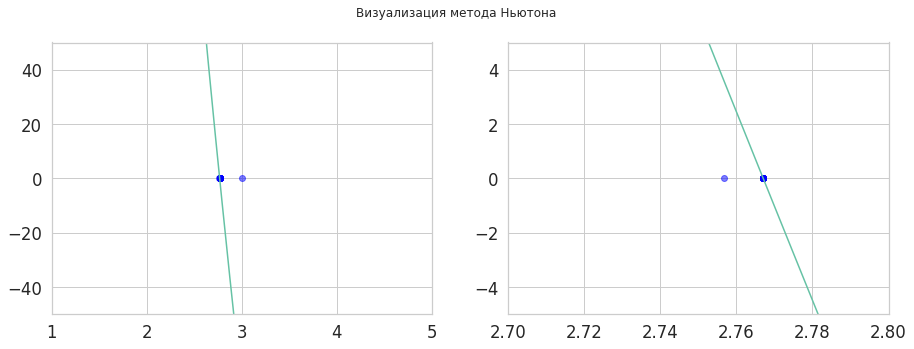

In [136]:
def dloglike_dk(k):
    n = wind.size
    Xk = wind**k
    logX = np.log(wind)
    return n/k + logX.sum() - (logX*Xk).sum(axis=0)/Xk.mean(axis=0)

def d2loglike_dk2(k):
    n = wind.size
    Xk = wind**k
    logX = np.log(wind)
    return -n/k**2 - (Xk * logX**2).sum()/Xk.mean() + (((Xk * logX).sum())**2)/(n * (Xk.mean()**2))

def Newton(start, iterations):
    ans = start
    sequence = [ans]
    for _ in range(iterations):
        ans = ans - dloglike_dk(ans)/d2loglike_dk2(ans)
        sequence.append(ans)
    return ans, np.array(sequence)

k = np.linspace(1, 10, 1000)
iters = 15
start = 3
calc = Newton(start, iters)
cmax2 = calc[0]
lmax2 = lambd(cmax2)

print(f"Результат вычислений методом Ньютона k={cmax:.5f}, lambda={lmax:.5f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
for ax, xlim, ylim in zip((ax1, ax2), [(1, 5), (2.7, 2.8)], [(-50, 50), (-5, 5)]):
    ax.plot(k, [dloglike_dk(k_i) for k_i in k])
    ax.scatter(calc[1], np.zeros(shape=iters+1), alpha=0.5, color='b')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

fig.suptitle('Визуализация метода Ньютона')

plt.show()

**Вывод:**

Применили 2 различных вычислительных метода поиска MLE в случае, когда это сложно сделать теоретически (хоть некоторые теоретические выкладки и оказались необходимы)

С одной стороны, первый метод оказался несколько сложнее организован, но он не требовал почти никаких знаний о природе случайной величины (только названия распределения для модели). Кроме того, вычислительно он работал куда медленее и требовал больше ресурсов

С другой стороны, имея некоторые знания о распределении, мы смогли применить метод Ньютона, который за 15 шагов своей работы дал очень точную оценку

Таким образом, некоторые теоретически знания о природе распределения позволяют сильно улучшить время работы программы. Однако, небольшое знание о природе распределения еще не приговор и в этом случае все равно есть возможность сделать 